# Stroke Prediction

Group 14
Group member: Xichen Liu, Duo Zhao, Keming Xu, Wenshu Yang, Rodolph Mesadieu

In [88]:
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Data Pre-processing

Read data and general view

In [89]:
stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv')
print(f'Shape of dataset: {stroke_data.shape}')
stroke_data.head()

Shape of dataset: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


*Feature description:*
> * **id**: Unique identifier
> * **gender**: Male, Female, or Other
> * **age**: Age of the patient
> * **hypertension**: If the patient has hypertension
> * **heart_disease**: If the patient has any heart diseases
> * **ever_married**: If the patient has ever get married
> * **work_type**: Types of patients' jobs
> * **Residence_type**: Residence regions
> * **avg_glucose**: Average glucose level in blood
> * **bmi**: Body mass index
> * **smoking_status**: Frequency of smoking
> * **stroke**: If the patient has stroke.

##### Missing values

In [90]:
print('Missing values in each features:')
print(stroke_data.isna().sum())

Missing values in each features:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Looks good that only bmi contains come missing values.

##### Duplicates

In [91]:
print(f'Duplicates in dataset: {stroke_data.duplicated().sum()} ({np.round(100 * stroke_data.duplicated().sum() / len(stroke_data), 2)}%)')

Duplicates in dataset: 0 (0.0%)


##### Cardinality of features

In [92]:
stroke_data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

Except targets, we got 7 categorical features, 3 continuous features, and 1 qualitative feature(id)

##### Data types

In [93]:
stroke_data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

We will need to transform the object data to be numeric so that we can train models

## Exploratory data analysis(EDA)

##### Target distribution

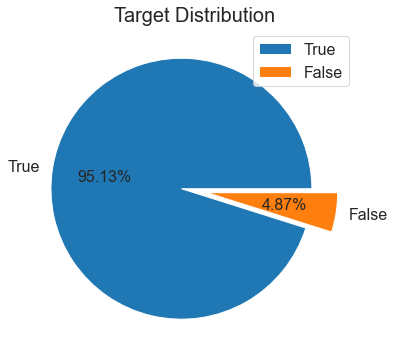

In [94]:
plt.figure(figsize = (6, 6))
plt.pie(stroke_data['stroke'].value_counts(), explode = [0.1, 0.1], labels = ['True', 'False'], autopct = '%.2f%%', shadow = False, textprops = {'fontsize': 16})
plt.title('Target Distribution', fontdict = {'fontsize': 20})
plt.legend(prop = {'size': 16})
plt.show()

Distribution is not even, may need under sampling or over sampling

##### Continuous features

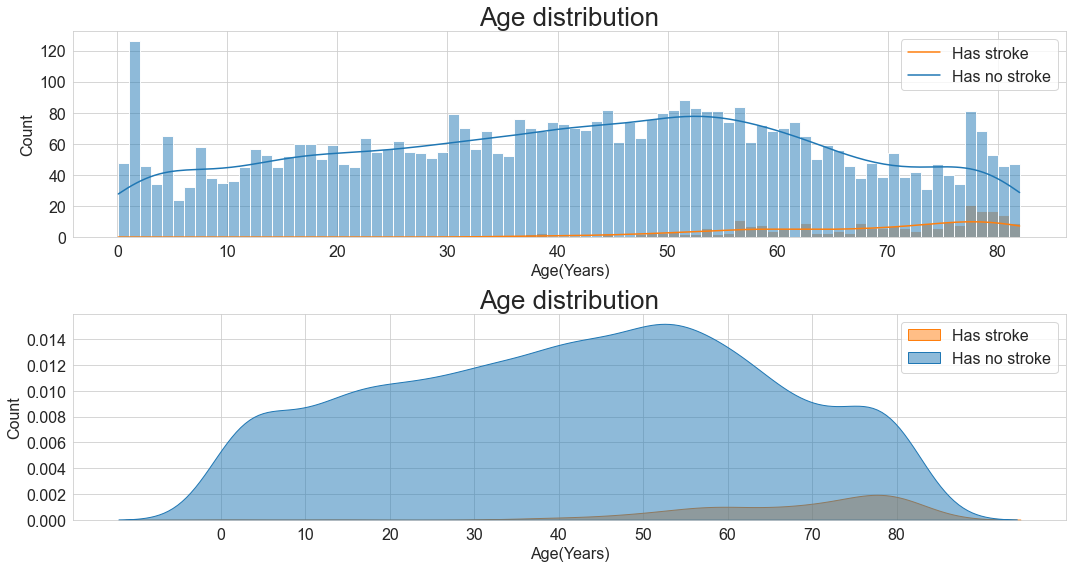

In [95]:
fig = plt.figure(figsize = (15, 8))

ax = fig.add_subplot(2, 1, 1)
sns.histplot(data = stroke_data, x = 'age', axes = ax, hue = 'stroke', binwidth = 1, kde = True)
plt.legend(labels = ['Has stroke', 'Has no stroke'], prop = {'size': 16})
plt.title('Age distribution', fontdict = {'fontsize': 26})
plt.xlabel('Age(Years)', fontdict = {'fontsize': 16})
plt.xticks(np.arange(0, 90, 10), fontsize = 16)
plt.ylabel('Count', fontdict = {'fontsize': 16})
plt.yticks(fontsize = 16)

ax = fig.add_subplot(2, 1, 2)
sns.kdeplot(data = stroke_data, x = 'age', axes = ax, hue = 'stroke', shade  = True, alpha = 0.5)
plt.legend(labels = ['Has stroke', 'Has no stroke'], prop = {'size': 16})
plt.title('Age distribution', fontdict = {'fontsize': 26})
plt.xlabel('Age(Years)', fontdict = {'fontsize': 16})
plt.xticks(np.arange(0, 90, 10), fontsize = 16)
plt.ylabel('Count', fontdict = {'fontsize': 16})
plt.yticks(fontsize = 16)

fig.tight_layout()
plt.show()

Easy to find out that:
Patients under 40 years old barely have stroke
A small portion of patients from 40 to 65 years old have stroke
A greater percentage of patients over 70 years old have stroke
So we may divide the age feature into three groups

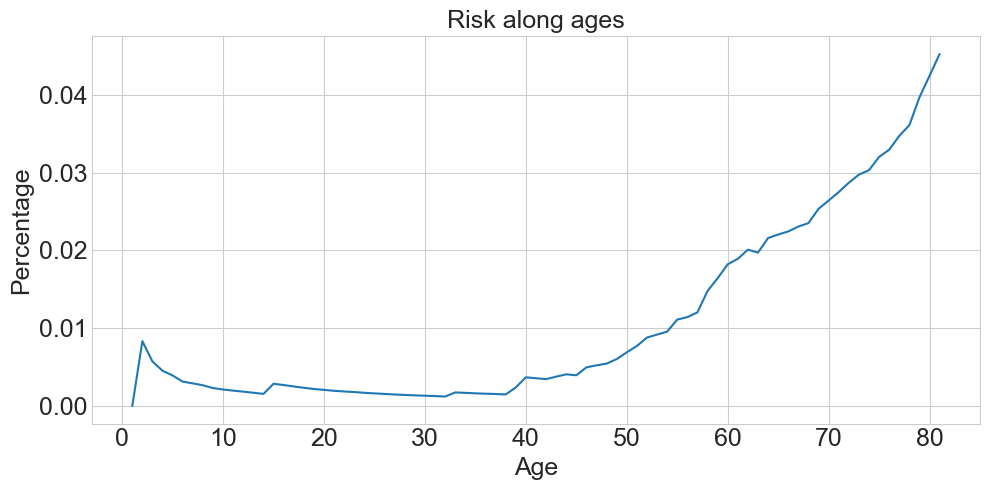

In [96]:
# Risk of getting stroke along age
fig = plt.figure(figsize = (10, 5), dpi = 100)

stroke_data['age'] = stroke_data['age'].astype(int)

rate = []
for i in range(stroke_data['age'].min(), stroke_data['age'].max()):
    rate.append(stroke_data[stroke_data['age'] < i]['stroke'].sum() / len(stroke_data[stroke_data['age'] < i]['stroke']))

sns.lineplot(data = rate)
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.tick_params(axis = u'both', which = u'both',length = 0)
plt.title('Risk along ages', fontdict = {'fontsize': 18})
plt.xlabel('Age', fontdict = {'fontsize': 18})
plt.ylabel('Percentage', fontdict = {'fontsize': 18})

fig.tight_layout()
plt.show()

Risk of getting stroke increases as age increases.

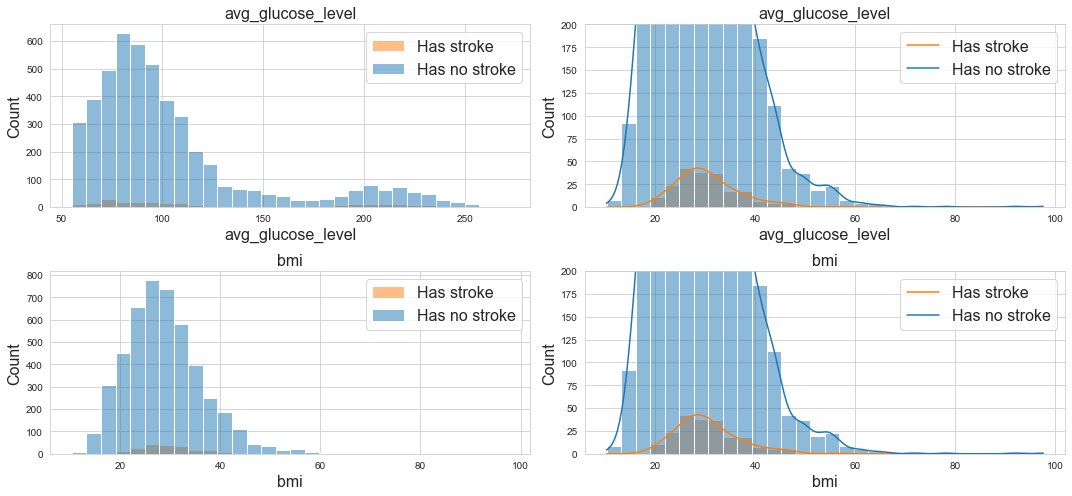

In [97]:
# Glucose and bmi
glu_bmi = ['avg_glucose_level', 'bmi']

fig = plt.figure(figsize = (15, 7))
for i, var in enumerate(glu_bmi):
    ax = fig.add_subplot(2, 2, 2 * i + 1)
    sns.histplot(data = stroke_data, x = var, axes = ax, hue = 'stroke', kde = False, bins = 30)
    ax.set_title(var, fontdict = {'fontsize': 16})
    ax.legend(labels = ['Has stroke', 'Has no stroke'], prop = {'size': 16})
    ax.set_xlabel(var, fontdict = {'fontsize': 16})
    ax.set_ylabel('Count', fontdict = {'fontsize': 16})

    ax = fig.add_subplot(2, 2, 2 * i + 2)
    sns.histplot(data = stroke_data, x = 'bmi', axes = ax, hue = 'stroke', kde = True, bins = 30)
    ax.set_title(var, fontdict = {'fontsize': 16})
    ax.legend(labels = ['Has stroke', 'Has no stroke'], prop = {'size': 16})
    ax.set_xlabel(var, fontdict = {'fontsize': 16})
    ax.set_ylabel('Count', fontdict = {'fontsize': 16})
    ax.set_ylim([0, 200])

fig.tight_layout()
plt.show()

The general distribution of the whether a patient has stroke or not relates to average glucose level and bmi are similar.
In other words, they can be combined into one feature.

In [ ]:
# Age and glucose/bmi
fig = plt.figure(figsize = (10, 16), dpi = 100)

ax = fig.add_subplot(2, 1, 1)

##### Categorical features

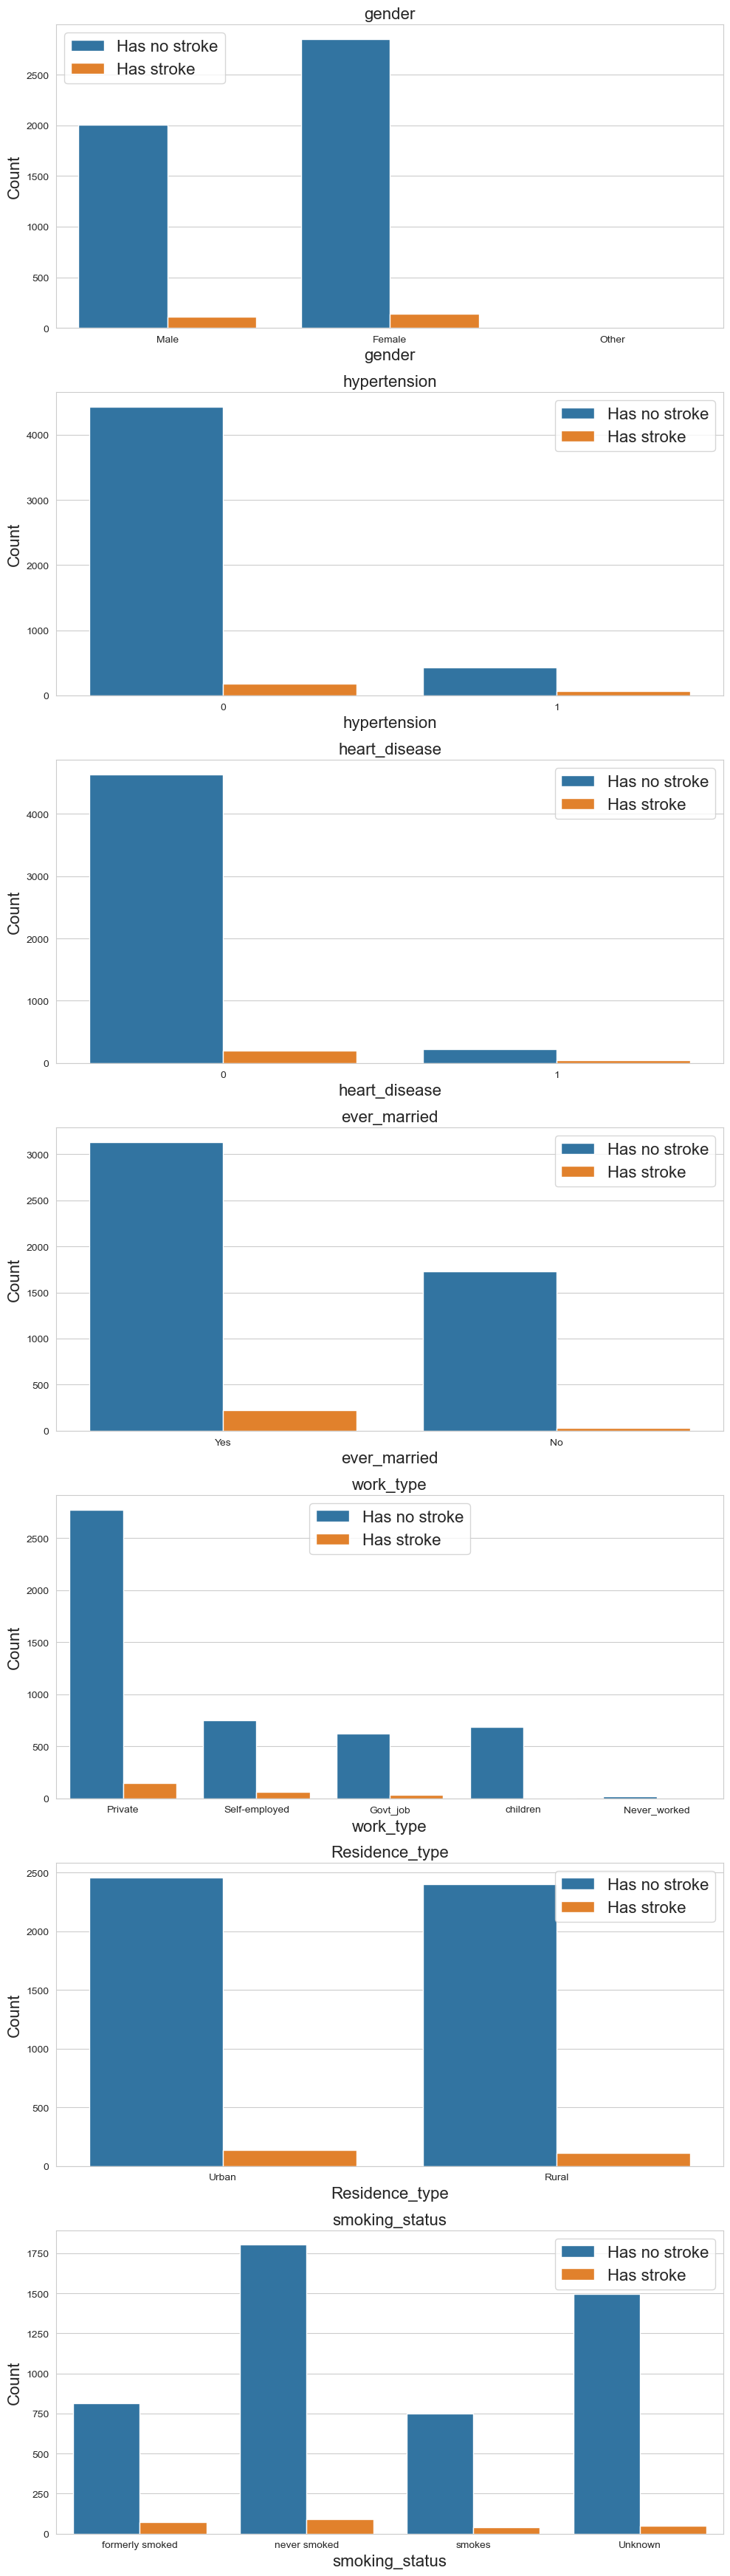

In [106]:
cat_fea = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
fig = plt.figure(figsize = (10, 35), dpi = 100)
for i, var in enumerate(cat_fea):
    ax = fig.add_subplot(7, 1, i + 1)
    sns.countplot(data = stroke_data, x = var, axes = ax, hue = 'stroke')
    ax.set_title(var, fontdict = {'fontsize': 16})
    ax.legend(labels = ['Has no stroke', 'Has stroke'], prop = {'size': 16})
    ax.set_xlabel(var, fontdict = {'fontsize': 16})
    ax.set_ylabel('Count', fontdict = {'fontsize': 16})
fig.tight_layout()
plt.show()

##### Feature relations

In [99]:
# A general view
fig = px.parallel_categories(stroke_data[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
                                          'work_type', 'Residence_type', 'smoking_status', 'stroke']],
                             color = 'stroke', color_continuous_scale = px.colors.sequential.Darkmint)
fig.show()

In [100]:
# Correlation between features and target
features = list(stroke_data.columns)
